In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm dask pyarrow

In [36]:
# import neccessary libraries
import os
import pandas as pd
from glob import glob
import re
import numpy as np
#import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool


## Load dataset

In [4]:
base_path = "/Users/siha/Documents/GitHub/Micron-AI-Challenge/train"

In [5]:
# Utility function to load the parquet files
def load_all_parquet(pattern):
    files = glob(pattern)
    return pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)


In [6]:
incoming_run_df = load_all_parquet(os.path.join(base_path, "incoming_run_data_*.parquet"))
incoming_run_df

,Tool ID,Run Start Time,Run End Time,Run ID,Process Step,Step ID,Time Stamp,Sensor Name,Sensor Value
0,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_0,2023-12-31 00:00:00.000000000,Sensor_1,195.469116
1,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_0,2023-12-31 00:00:01.000000002,Sensor_1,195.497040
2,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_0,2023-12-31 00:00:01.999999997,Sensor_1,195.497025
3,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_1,2023-12-31 00:00:03.000000000,Sensor_1,195.474823
4,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_1,2023-12-31 00:00:04.000000002,Sensor_1,195.496368
...,...,...,...,...,...,...,...,...,...
82896501,a060c807-dbdb-5de3-9cd7-0c596234a3d7,2024-01-03 23:43:15,2024-01-03 23:55:50,6908f294-5178-50bc-ba5b-5293435ba574,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-03 23:51:09.000000000,Sensor_9,2.702956
82896502,a060c807-dbdb-5de3-9cd7-0c596234a3d7,2024-01-03 23:43:15,2024-01-03 23:55:50,6908f294-5178-50bc-ba5b-5293435ba574,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-03 23:51:10.000000002,Sensor_9,2.957552
82896503,a060c807-dbdb-5de3-9cd7-0c596234a3d7,2024-01-03 23:43:15,2024-01-03 23:55:50,6908f294-5178-50bc-ba5b-5293435ba574,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-03 23:51:10.999999998,Sensor_9,-0.477442
82896504,a060c807-dbdb-5de3-9cd7-0c596234a3d7,2024-01-03 23:43:15,2024-01-03 23:55:50,6908f294-5178-50bc-ba5b-5293435ba574,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-03 23:51:12.000000000,Sensor_9,-1.214340


In [7]:
run_data_df = load_all_parquet(os.path.join(base_path, "run_data_*.parquet"))
run_data_df

,Tool ID,Run Start Time,Run End Time,Run ID,Process Step,Consumable Life,Step ID,Time Stamp,Sensor Name,Sensor Value
0,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_0,2024-01-01 00:00:00.000000000,Sensor_A,-0.024998
1,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_0,2024-01-01 00:00:01.000000002,Sensor_A,0.073171
2,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_1,2024-01-01 00:00:01.999999997,Sensor_A,0.070384
3,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_1,2024-01-01 00:00:03.000000000,Sensor_A,0.064502
4,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_1,2024-01-01 00:00:04.000000002,Sensor_A,-0.097807
...,...,...,...,...,...,...,...,...,...,...
41220745,ad28cd71-3811-543c-80a1-a440468a49d7,2024-01-04 04:38:15,2024-01-04 04:50:50,84a6fa0a-721c-576c-97f6-1f5bfe46de4a,22c8716b-1c14-525a-8c0a-0473ec7aa99e,67.854195,Step_12,2024-01-04 04:48:06.000000000,Sensor_O,775.952576
41220746,ad28cd71-3811-543c-80a1-a440468a49d7,2024-01-04 04:38:15,2024-01-04 04:50:50,84a6fa0a-721c-576c-97f6-1f5bfe46de4a,22c8716b-1c14-525a-8c0a-0473ec7aa99e,67.854195,Step_12,2024-01-04 04:48:07.000000002,Sensor_O,771.639465
41220747,ad28cd71-3811-543c-80a1-a440468a49d7,2024-01-04 04:38:15,2024-01-04 04:50:50,84a6fa0a-721c-576c-97f6-1f5bfe46de4a,22c8716b-1c14-525a-8c0a-0473ec7aa99e,67.854195,Step_12,2024-01-04 04:48:07.999999998,Sensor_O,774.632263
41220748,ad28cd71-3811-543c-80a1-a440468a49d7,2024-01-04 04:38:15,2024-01-04 04:50:50,84a6fa0a-721c-576c-97f6-1f5bfe46de4a,22c8716b-1c14-525a-8c0a-0473ec7aa99e,67.854195,Step_12,2024-01-04 04:48:09.000000000,Sensor_O,774.416626


In [8]:
metrology_df = load_all_parquet(os.path.join(base_path, "metrology_data*.parquet"))
metrology_df

,Run ID,Run Start Time,Run End Time,X_index,Y_index,X,Y,Point Index,Measurement
0,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,1,23,-143.877551,-9.183673,3,10.104178
1,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,1,29,-143.877551,27.551020,48,10.064924
2,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,2,34,-137.755102,58.163265,43,10.039947
3,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,3,14,-131.632653,-64.285714,20,10.139306
4,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,5,39,-119.387755,88.775510,8,10.037289
...,...,...,...,...,...,...,...,...,...
202855,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,44,11,119.387755,-82.653061,5,10.141212
202856,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,44,39,119.387755,88.775510,22,10.285743
202857,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,46,26,131.632653,9.183673,46,10.305865
202858,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,48,21,143.877551,-21.428571,16,10.325929


In [11]:
# save the loaded df

# Define save path
save_folder = "loaded_data_df"
os.makedirs(save_folder, exist_ok=True)

# Save each DataFrame to Parquet
incoming_run_df.to_parquet(os.path.join(save_folder, "incoming_run_df.parquet"))
run_data_df.to_parquet(os.path.join(save_folder, "run_data_df.parquet"))
metrology_df.to_parquet(os.path.join(save_folder, "metrology_df.parquet"))


## EDA

In [8]:
# Display column names of each DataFrame

print("Columns in incoming_run_df:")
print(incoming_run_df.columns.tolist())

print("\nColumns in run_data_df:")
print(run_data_df.columns.tolist())

print("\nColumns in metrology_df:")
print(metrology_df.columns.tolist())

Columns in incoming_run_df:
['Tool ID', 'Run Start Time', 'Run End Time', 'Run ID', 'Process Step', 'Step ID', 'Time Stamp', 'Sensor Name', 'Sensor Value']

Columns in run_data_df:
['Tool ID', 'Run Start Time', 'Run End Time', 'Run ID', 'Process Step', 'Consumable Life', 'Step ID', 'Time Stamp', 'Sensor Name', 'Sensor Value']

Columns in metrology_df:
['Run ID', 'Run Start Time', 'Run End Time', 'X_index', 'Y_index', 'X', 'Y', 'Point Index', 'Measurement']


In [13]:
# Function to check uniqueness of Run ID in a dataframe
def analyze_run_ids(df, df_name):
    print(f"\n🔍 Checking Run ID uniqueness in {df_name}...")
    
    # Check if Run ID is unique
    is_unique = df['Run ID'].is_unique
    print(f"🧠 Is Run ID unique in {df_name}? ➜ {is_unique}")
    
    # If not unique, show duplicated Run IDs and how many times they appear
    if not is_unique:
        duplicates = df['Run ID'].value_counts()
        duplicates = duplicates[duplicates > 1]
        print(f"❌ Non-unique Run ID values in {df_name} (count > 1):")
        print(duplicates.head(10))  # Show top 10 non-unique cases
    
    # Show top 10 unique Run IDs (alphabetical/numerical)
    unique_run_ids = df['Run ID'].drop_duplicates().sort_values().head(10)
    print(f"✅ Top 10 unique Run IDs in {df_name}:")
    print(unique_run_ids.tolist())

# Run for all three datasets
analyze_run_ids(incoming_run_df, "incoming_run_df")
analyze_run_ids(run_data_df, "run_data_df")
analyze_run_ids(metrology_df, "metrology_df")



🔍 Checking Run ID uniqueness in incoming_run_df...
🧠 Is Run ID unique in incoming_run_df? ➜ False
❌ Non-unique Run ID values in incoming_run_df (count > 1):
Run ID
988a5f1a-5950-56b2-9bcf-29c5aea70677    22960
e8f422bc-7dbe-5282-84ab-dff077d86b69    22960
b8ea879d-b658-5f77-85e6-69ba24ae4fb8    22960
386ca225-eca0-583d-bba3-267e1f69ebd9    22960
aa151ba8-2a3e-5801-a43b-c6ad0bb18927    22960
bc3c0a5f-0372-57ba-b8ed-3437a98bec6f    22960
fce3e95e-2c05-59ce-8303-f21b0b3aed53    22960
c891faaa-1df6-5216-b881-995044338c25    22919
f46fac3c-98d6-59fb-bcfd-6e9db02708dc    22919
f8a4c591-1e40-5faa-9b5f-73fbc62d514d    22919
Name: count, dtype: int64
✅ Top 10 unique Run IDs in incoming_run_df:
['000f424f-667d-54a2-bbbd-9624c4071465', '001466b9-ee4c-5642-8e93-0a501ce4e9d9', '002d6c65-b86f-5153-a2d8-206e59da6307', '002fdc18-a36b-5188-a5e3-9e1d59697a6b', '004379ac-3743-5811-bb3b-d1821813b2d2', '006d7bd0-505e-5b9d-9b51-2789a737ec4f', '007751c5-c5d3-53f1-8243-465418d2c94d', '008040f7-baf4-5d25-93e8

In [17]:
# Function to analyze RunId uniqueness and duplicates in a DataFrame
def analyze_run_ids_extended(df, df_name):
    print(f"\n🔍 Analyzing {df_name}")

    # Total rows and unique RunIds
    total_rows = len(df)
    unique_run_ids = df['Run ID'].nunique()
    print(f"📊 Total rows: {total_rows}")
    print(f"🔢 Unique RunIds: {unique_run_ids}")
    
    # Check if RunId is unique
    is_unique = df['Run ID'].is_unique
    print(f"🧠 Is RunId unique? ➜ {is_unique}")
    
    # Find duplicated RunId values (appear more than once)
    runid_counts = df['Run ID'].value_counts()
    non_unique_runids = runid_counts[runid_counts > 1]
    num_non_unique_runids = len(non_unique_runids)
    print(f"❌ Number of non-unique RunIds (appearing >1 time): {num_non_unique_runids}")
    
    # Check if full rows are duplicates
    duplicated_rows = df.duplicated()
    num_duplicated_rows = duplicated_rows.sum()
    print(f"📎 Number of fully duplicated rows: {num_duplicated_rows}")
    
    # Show sample non-unique RunId counts
    if num_non_unique_runids > 0:
        print("\n🔁 Sample non-unique RunId occurrences (top 5):")
        print(non_unique_runids.head(5))

    # Show top 10 unique RunIds
    print("\n✅ Top 10 unique RunIds:")
    print(df['Run ID'].drop_duplicates().sort_values().head(10).tolist())

# Run the analysis for all three DataFrames
analyze_run_ids_extended(incoming_run_df, "incoming_run_df")
analyze_run_ids_extended(run_data_df, "run_data_df")
analyze_run_ids_extended(metrology_df, "metrology_df")



🔍 Analyzing incoming_run_df
📊 Total rows: 82896506
🔢 Unique RunIds: 4140
🧠 Is RunId unique? ➜ False
❌ Number of non-unique RunIds (appearing >1 time): 4140
📎 Number of fully duplicated rows: 0

🔁 Sample non-unique RunId occurrences (top 5):
Run ID
988a5f1a-5950-56b2-9bcf-29c5aea70677    22960
e8f422bc-7dbe-5282-84ab-dff077d86b69    22960
b8ea879d-b658-5f77-85e6-69ba24ae4fb8    22960
386ca225-eca0-583d-bba3-267e1f69ebd9    22960
aa151ba8-2a3e-5801-a43b-c6ad0bb18927    22960
Name: count, dtype: int64

✅ Top 10 unique RunIds:
['000f424f-667d-54a2-bbbd-9624c4071465', '001466b9-ee4c-5642-8e93-0a501ce4e9d9', '002d6c65-b86f-5153-a2d8-206e59da6307', '002fdc18-a36b-5188-a5e3-9e1d59697a6b', '004379ac-3743-5811-bb3b-d1821813b2d2', '006d7bd0-505e-5b9d-9b51-2789a737ec4f', '007751c5-c5d3-53f1-8243-465418d2c94d', '008040f7-baf4-5d25-93e8-d7f12597b853', '00862337-2cc0-5b34-b5e1-45588e935c39', '00970470-f2f4-5759-86c4-f31fe6abdc5a']

🔍 Analyzing run_data_df
📊 Total rows: 41220750
🔢 Unique RunIds: 4140

### Inference :
- Run ID is a unique ID for a production run
- But each run has : 
    -  Hundreds of sensor readings (at different times)
    - And 49 measurement points on the wafer (X, Y grid)
- so:
    - incoming_run_df and run_data_df have many rows per RunId because of time-series data.
    - metrology_df has exactly 49 rows per RunId — one per (X, Y) measurement point.
- hence, we cannot stack the datasets vertically (no concat!). we need to transform the sensor data into features first. so for each RunId, we have to convert the time-series into a single row of features. aka aggregate sensor data
- Once we’ve created these per-RunId feature tables (from run_data and incoming_run_data), we can merge them like this:
    - run_features: summary features from run_data
    - incoming_features: summary features from incoming_run_data
- Merge them on RunId:
    - full_features = run_features ⨝ incoming_features
    - Now you have all useful numeric features per run.
- then we take metrology_df and merge in the sensor features:
    - final_df = metrology_df ⨝ full_features on RunId
    - Now each (X, Y) point has its measurement (target) and the same run-level features as inputs.


In [30]:
def eda_pipeline(df, name="DataFrame", check_sensor=False, plot=False):
    print(f"\n📊 EDA Report for: {name}")
    print("-" * 50)
    
    # Shape and column overview
    print(f"🔹 Shape: {df.shape}")
    print(f"🔹 Columns: {df.columns.tolist()}")
    
    # Dtypes
    print("\n📦 Data Types:")
    print(df.dtypes)
    
    # Nulls
    print("\n🧼 Null Values:")
    print(df.isnull().sum().sort_values(ascending=False))
    
    # Duplicates
    print(f"\n🧾 Duplicate Rows: {df.duplicated().sum()}")
    
    # Summary stats
    print("\n📈 Summary Statistics (numeric columns):")
    display(df.describe())
    
    # Outlier checks for key fields
    if check_sensor and "SensorValue" in df.columns:
        print("\n🚨 SensorValue Outlier Stats:")
        print(df["SensorValue"].describe(percentiles=[.01, .25, .5, .75, .99]))
        if plot:
            sns.histplot(df["SensorValue"], bins=100, kde=True)
            plt.title(f"{name}: SensorValue Distribution")
            plt.show()
    
    elif "Measurement" in df.columns:
        print("\n🎯 Measurement Outlier Stats:")
        print(df["Measurement"].describe(percentiles=[.01, .25, .5, .75, .99]))
        if plot:
            sns.histplot(df["Measurement"], bins=50, kde=True)
            plt.title(f"{name}: Measurement Distribution")
            plt.show()
    
    # Unique RunId and SensorName (if applicable)
    if "RunId" in df.columns:
        print(f"\n🔢 Unique RunIds: {df['RunId'].nunique()}")
    if "SensorName" in df.columns:
        print(f"🧪 Unique SensorNames: {df['SensorName'].nunique()}")
    if "ToolId" in df.columns:
        print(f"🛠️ Unique ToolIds: {df['ToolId'].nunique()}")
    if "StepId" in df.columns:
        print(f"🧱 Unique StepIds: {df['StepId'].nunique()}")

    # Optional: Time range check
    if "TimeStamp" in df.columns:
        try:
            df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], errors='coerce')
            print(f"\n⏱ Time range: {df['TimeStamp'].min()} to {df['TimeStamp'].max()}")
        except Exception as e:
            print("Could not parse TimeStamp:", e)

    print("-" * 50)


In [31]:
# For incoming_run_df (sensor data)
eda_pipeline(incoming_run_df, name="incoming_run_df", check_sensor=True, plot=True)


📊 EDA Report for: incoming_run_df
--------------------------------------------------
🔹 Shape: (82896506, 9)
🔹 Columns: ['Tool ID', 'Run Start Time', 'Run End Time', 'Run ID', 'Process Step', 'Step ID', 'Time Stamp', 'Sensor Name', 'Sensor Value']

📦 Data Types:
Tool ID                   object
Run Start Time    datetime64[ns]
Run End Time      datetime64[ns]
Run ID                    object
Process Step              object
Step ID                   object
Time Stamp        datetime64[ns]
Sensor Name               object
Sensor Value             float32
dtype: object

🧼 Null Values:
Tool ID           0
Run Start Time    0
Run End Time      0
Run ID            0
Process Step      0
Step ID           0
Time Stamp        0
Sensor Name       0
Sensor Value      0
dtype: int64

🧾 Duplicate Rows: 0

📈 Summary Statistics (numeric columns):


,Run Start Time,Run End Time,Time Stamp,Sensor Value
count,82896506,82896506,82896506,8.289651e+07
mean,2024-01-01 22:58:26.099650304,2024-01-01 23:10:50.835380480,2024-01-01 23:02:30.820433920,3.190349e+02
min,2023-12-31 00:00:00,2023-12-31 00:11:58,2023-12-31 00:00:00,-2.960740e+01
25%,2023-12-31 23:02:00,2023-12-31 23:14:32,2023-12-31 23:05:44,3.786640e+00
50%,2024-01-01 22:45:00,2024-01-01 22:57:30,2024-01-01 22:48:12,4.378229e+01
75%,2024-01-02 22:50:12,2024-01-02 23:02:34,2024-01-02 22:54:39,2.045364e+02
max,2024-01-03 23:43:15,2024-01-03 23:55:50,2024-01-03 23:51:13.000000002,2.043282e+04
std,NaN,NaN,NaN,7.257034e+02


--------------------------------------------------


In [32]:
# For run_data_df
eda_pipeline(run_data_df, name="run_data_df", check_sensor=True, plot=True)


📊 EDA Report for: run_data_df
--------------------------------------------------
🔹 Shape: (41220750, 10)
🔹 Columns: ['Tool ID', 'Run Start Time', 'Run End Time', 'Run ID', 'Process Step', 'Consumable Life', 'Step ID', 'Time Stamp', 'Sensor Name', 'Sensor Value']

📦 Data Types:
Tool ID                    object
Run Start Time     datetime64[ns]
Run End Time       datetime64[ns]
Run ID                     object
Process Step               object
Consumable Life           float32
Step ID                    object
Time Stamp         datetime64[ns]
Sensor Name                object
Sensor Value              float32
dtype: object

🧼 Null Values:
Tool ID            0
Run Start Time     0
Run End Time       0
Run ID             0
Process Step       0
Consumable Life    0
Step ID            0
Time Stamp         0
Sensor Name        0
Sensor Value       0
dtype: int64

🧾 Duplicate Rows: 0

📈 Summary Statistics (numeric columns):


,Run Start Time,Run End Time,Consumable Life,Time Stamp,Sensor Value
count,41220750,41220750,4.122075e+07,41220750,4.122075e+07
mean,2024-01-02 13:52:46.073672192,2024-01-02 14:05:21.073666304,2.514611e+02,2024-01-02 13:58:18.966889472,7.156060e+02
min,2024-01-01 00:00:00,2024-01-01 00:12:35,5.155509e-01,2024-01-01 00:00:00,-1.463412e+09
25%,2024-01-01 18:30:00,2024-01-01 18:42:35,1.456270e+02,2024-01-01 18:39:08,6.949232e+00
50%,2024-01-02 13:52:45,2024-01-02 14:05:20,2.530453e+02,2024-01-02 13:53:16,1.478311e+02
75%,2024-01-03 08:57:55,2024-01-03 09:10:30,3.604619e+02,2024-01-03 09:09:15,7.434313e+02
max,2024-01-04 04:38:15,2024-01-04 04:50:50,4.942603e+02,2024-01-04 04:50:18,3.913374e+08
std,NaN,NaN,1.231368e+02,NaN,3.190811e+05


--------------------------------------------------



📊 EDA Report for: metrology_df
--------------------------------------------------
🔹 Shape: (202860, 9)
🔹 Columns: ['Run ID', 'Run Start Time', 'Run End Time', 'X_index', 'Y_index', 'X', 'Y', 'Point Index', 'Measurement']

📦 Data Types:
Run ID                    object
Run Start Time    datetime64[ns]
Run End Time      datetime64[ns]
X_index                    int32
Y_index                    int32
X                        float64
Y                        float64
Point Index                int64
Measurement              float64
dtype: object

🧼 Null Values:
Run ID            0
Run Start Time    0
Run End Time      0
X_index           0
Y_index           0
X                 0
Y                 0
Point Index       0
Measurement       0
dtype: int64

🧾 Duplicate Rows: 0

📈 Summary Statistics (numeric columns):


,Run Start Time,Run End Time,X_index,Y_index,X,Y,Point Index,Measurement
count,202860,202860,202860.000000,202860.000000,202860.000000,202860.000000,202860.00000,202860.000000
mean,2024-01-02 13:54:03.815217408,2024-01-02 14:06:38.815217152,24.428571,25.020408,-0.437318,3.186172,24.00000,10.223926
min,2024-01-01 00:00:00,2024-01-01 00:12:35,1.000000,1.000000,-143.877551,-143.877551,0.00000,9.871226
25%,2024-01-01 18:30:00,2024-01-01 18:42:35,14.000000,14.000000,-64.285714,-64.285714,12.00000,10.107717
50%,2024-01-02 13:52:45,2024-01-02 14:05:20,26.000000,26.000000,9.183673,9.183673,24.00000,10.178120
75%,2024-01-03 09:15:30,2024-01-03 09:28:05,36.000000,34.000000,70.408163,58.163265,36.00000,10.297302
max,2024-01-04 04:38:15,2024-01-04 04:50:50,48.000000,48.000000,143.877551,143.877551,48.00000,11.563465
std,NaN,NaN,13.413398,12.946531,82.122847,79.264473,14.14217,0.169777



🎯 Measurement Outlier Stats:
count    202860.000000
mean         10.223926
std           0.169777
min           9.871226
1%            9.984665
25%          10.107717
50%          10.178120
75%          10.297302
99%          10.777424
max          11.563465
Name: Measurement, dtype: float64


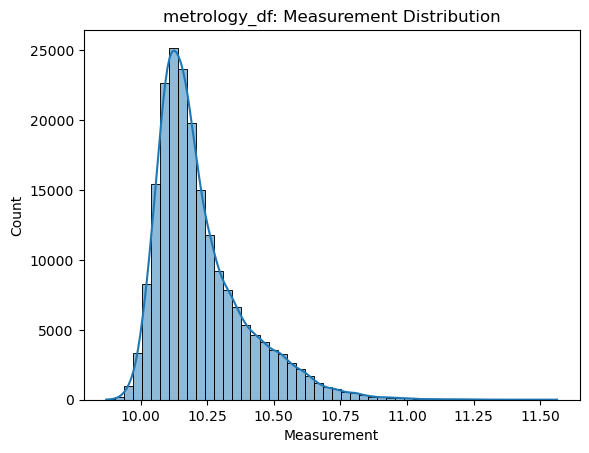

--------------------------------------------------


In [33]:
# For metrology_df
eda_pipeline(metrology_df, name="metrology_df", check_sensor=False, plot=True)

## Data Preprocessing

#### Filtering outliers 

In [13]:
# Step 1: Apply per-sensor filtering (using your existing function)
def clean_sensor_value_per_sensor(df, sensor_col='Sensor Name', value_col='Sensor Value', lower_pct=0.001, upper_pct=0.999):
    cleaned_dfs = []
    sensors = df[sensor_col].unique()
    print(f"\nCleaning sensor values for {len(sensors)} sensors...")

    for sensor in sensors:
        sub_df = df[df[sensor_col] == sensor].copy()
        low = sub_df[value_col].quantile(lower_pct)
        high = sub_df[value_col].quantile(upper_pct)
        cleaned = sub_df[(sub_df[value_col] >= low) & (sub_df[value_col] <= high)]
        cleaned_dfs.append(cleaned)
        print(f"{sensor}: Removed {len(sub_df) - len(cleaned)} outliers ({len(cleaned)} remaining)")

    return pd.concat(cleaned_dfs, ignore_index=True)

In [14]:
# Step 2: Clean both datasets
filtered_incoming = clean_sensor_value_per_sensor(incoming_run_df)
filtered_run = clean_sensor_value_per_sensor(run_data_df)


Cleaning sensor values for 41 sensors...
Sensor_1: Removed 4044 outliers (2017822 remaining)
Sensor_10: Removed 4044 outliers (2017822 remaining)
Sensor_11: Removed 4044 outliers (2017822 remaining)
Sensor_12: Removed 4044 outliers (2017822 remaining)
Sensor_13: Removed 4044 outliers (2017822 remaining)
Sensor_14: Removed 4044 outliers (2017822 remaining)
Sensor_15: Removed 4044 outliers (2017822 remaining)
Sensor_16: Removed 4044 outliers (2017822 remaining)
Sensor_17: Removed 4044 outliers (2017822 remaining)
Sensor_18: Removed 4044 outliers (2017822 remaining)
Sensor_19: Removed 4044 outliers (2017822 remaining)
Sensor_2: Removed 4044 outliers (2017822 remaining)
Sensor_20: Removed 4044 outliers (2017822 remaining)
Sensor_21: Removed 4044 outliers (2017822 remaining)
Sensor_22: Removed 4044 outliers (2017822 remaining)
Sensor_23: Removed 4044 outliers (2017822 remaining)
Sensor_24: Removed 4044 outliers (2017822 remaining)
Sensor_25: Removed 4044 outliers (2017822 remaining)
Sensor

In [ ]:
# Step 3: Save filtered DataFrames
filtered_path = "Micron-AI-Project/filtered_data"
os.makedirs(filtered_path, exist_ok=True)
filtered_incoming.to_parquet(os.path.join(filtered_path, "filtered_incoming_run_df.parquet"))
filtered_run.to_parquet(os.path.join(filtered_path, "filtered_run_data_df.parquet"))
print("\n✅ Filtered data saved to:", filtered_path)

#### Aggregating sensor data
what is done:
1. Aggregate run_data_df and incoming_run_df to get 1 row per RunId with summary features.
2. Merge these feature tables into one big full_features table using RunId.
3. Merge full_features into metrology_df on RunId to get final_df, ready for ML


In [15]:
# STEP 1️: Aggregate incoming_run_df — one row per RunId
incoming_agg = (
    filtered_incoming
    .groupby(['Run ID', 'Sensor Name'])['Sensor Value']
    .agg(['mean', 'std', 'min', 'max'])
    .reset_index()
)

# Pivot so each sensor becomes its own column
incoming_features = incoming_agg.pivot(index='Run ID', columns='Sensor Name')
incoming_features.columns = [f'in_{stat}_{sensor}' for sensor, stat in incoming_features.columns]
incoming_features.reset_index(inplace=True)


In [16]:
incoming_features

,Run ID,in_Sensor_1_mean,in_Sensor_10_mean,in_Sensor_11_mean,in_Sensor_12_mean,in_Sensor_13_mean,in_Sensor_14_mean,in_Sensor_15_mean,in_Sensor_16_mean,in_Sensor_17_mean,...,in_Sensor_38_max,in_Sensor_39_max,in_Sensor_4_max,in_Sensor_40_max,in_Sensor_41_max,in_Sensor_5_max,in_Sensor_6_max,in_Sensor_7_max,in_Sensor_8_max,in_Sensor_9_max
0,000f424f-667d-54a2-bbbd-9624c4071465,206.448059,413.006531,232.861435,81.848030,23.845398,0.584806,14.533963,884.280273,22.812201,...,209.181946,201.724274,1034.461670,7.215941,164.705887,6.837564,25.021969,3.865324,200.704514,206.060806
1,001466b9-ee4c-5642-8e93-0a501ce4e9d9,194.236099,3938.583984,209.686325,58.866673,254.058853,0.946503,9.574718,953.869934,27.779226,...,199.892654,208.951691,977.886841,8.581384,161.758652,0.566078,24.972841,5.123479,198.053513,198.752991
2,002d6c65-b86f-5153-a2d8-206e59da6307,206.032791,448.971191,355.617249,70.049484,59.853291,0.853933,8.157896,888.030823,15.115228,...,205.873871,196.582993,1002.075867,3.406497,154.630722,30.682104,23.354019,4.331479,203.008087,202.446838
3,002fdc18-a36b-5188-a5e3-9e1d59697a6b,201.813812,1877.682007,140.027725,53.051113,33.383583,0.641308,13.670773,907.587463,19.518837,...,208.203278,206.261230,1006.476440,5.885543,108.345398,7.055690,23.734806,3.925975,195.945847,210.524658
4,004379ac-3743-5811-bb3b-d1821813b2d2,203.785187,528.854065,37.719517,57.994770,94.059639,1.159251,14.497388,936.457031,18.283243,...,208.983627,198.256027,1025.975098,5.916732,336.782623,12.344835,23.794302,4.466114,197.897263,208.406158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135,ff982815-6caf-5d09-bc36-1a4461cd90cb,201.637299,444.049011,357.640839,75.581223,57.053799,0.844876,7.973206,941.411804,15.601706,...,201.754303,210.069626,1011.462585,3.339997,157.744629,30.721926,24.250835,4.669405,198.644913,208.135910
4136,ff9920ec-ea41-5f01-9485-005359e27565,205.575150,2223.903320,39.980289,65.387299,139.462128,0.777050,10.981102,905.425659,21.709986,...,195.052002,204.226639,978.617004,7.577688,213.874130,21.583694,23.319298,3.780404,198.616241,201.146439
4137,ffc86368-1339-558e-8f11-eac9ec32dcbb,194.056015,1364.489746,268.868164,87.550560,45.364468,1.135078,5.062354,933.121399,24.988741,...,209.558380,209.044922,989.547424,5.602102,83.305260,11.955264,24.074352,4.136656,201.300415,196.409683
4138,ffe07d3a-3f13-5300-8b66-dd3cf8fc4a1c,198.963440,805.911743,243.845123,55.013725,132.635635,0.622001,11.149495,936.128906,16.658007,...,205.699387,206.878265,1005.033081,8.943481,183.538116,19.019482,24.433771,5.336656,199.543579,200.007980


In [17]:
# STEP 2️: Aggregate run_data_df — one row per RunId
run_agg = (
    filtered_run
    .groupby(['Run ID', 'Sensor Name'])['Sensor Value']
    .agg(['mean', 'std', 'min', 'max'])
    .reset_index()
)

# Pivot and flatten
run_features = run_agg.pivot(index='Run ID', columns='Sensor Name')
run_features.columns = [f'run_{stat}_{sensor}' for sensor, stat in run_features.columns]
run_features.reset_index(inplace=True)


In [18]:
# STEP 3️: Merge run & incoming features
full_features = pd.merge(run_features, incoming_features, on='Run ID', how='outer')


In [19]:
# STEP 4️: Merge with metrology data (has 49 rows per RunId)
final_df = pd.merge(metrology_df, full_features, on='Run ID', how='left')


In [20]:
final_df

,Run ID,Run Start Time,Run End Time,X_index,Y_index,X,Y,Point Index,Measurement,run_Sensor_A_mean,...,in_Sensor_38_max,in_Sensor_39_max,in_Sensor_4_max,in_Sensor_40_max,in_Sensor_41_max,in_Sensor_5_max,in_Sensor_6_max,in_Sensor_7_max,in_Sensor_8_max,in_Sensor_9_max
0,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,1,23,-143.877551,-9.183673,3,10.104178,0.000807,...,206.425537,206.075989,971.981934,5.594242,86.687828,12.164294,24.638554,4.179875,209.329315,208.937363
1,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,1,29,-143.877551,27.551020,48,10.064924,0.000807,...,206.425537,206.075989,971.981934,5.594242,86.687828,12.164294,24.638554,4.179875,209.329315,208.937363
2,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,2,34,-137.755102,58.163265,43,10.039947,0.000807,...,206.425537,206.075989,971.981934,5.594242,86.687828,12.164294,24.638554,4.179875,209.329315,208.937363
3,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,3,14,-131.632653,-64.285714,20,10.139306,0.000807,...,206.425537,206.075989,971.981934,5.594242,86.687828,12.164294,24.638554,4.179875,209.329315,208.937363
4,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,5,39,-119.387755,88.775510,8,10.037289,0.000807,...,206.425537,206.075989,971.981934,5.594242,86.687828,12.164294,24.638554,4.179875,209.329315,208.937363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202855,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,44,11,119.387755,-82.653061,5,10.141212,0.003801,...,204.852921,209.022797,1032.859375,4.863607,134.358780,7.443811,24.393793,5.342276,208.428238,201.479340
202856,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,44,39,119.387755,88.775510,22,10.285743,0.003801,...,204.852921,209.022797,1032.859375,4.863607,134.358780,7.443811,24.393793,5.342276,208.428238,201.479340
202857,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,46,26,131.632653,9.183673,46,10.305865,0.003801,...,204.852921,209.022797,1032.859375,4.863607,134.358780,7.443811,24.393793,5.342276,208.428238,201.479340
202858,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,48,21,143.877551,-21.428571,16,10.325929,0.003801,...,204.852921,209.022797,1032.859375,4.863607,134.358780,7.443811,24.393793,5.342276,208.428238,201.479340


In [22]:
# final df checks!
final_df.isnull().sum().sort_values(ascending=False)

in_Sensor_1_std      343
in_Sensor_1_max      343
in_Sensor_1_mean     343
in_Sensor_1_min      343
in_Sensor_4_max       98
                    ... 
in_Sensor_20_mean      0
in_Sensor_21_mean      0
in_Sensor_22_mean      0
in_Sensor_23_mean      0
in_Sensor_9_max        0
Length: 233, dtype: int64

In [23]:
final_df.nunique().sort_values()

Y_index                  30
Y                        30
X_index                  33
X                        33
Point Index              49
                      ...  
in_Sensor_23_mean      4140
in_Sensor_19_max       4140
in_Sensor_2_std        4140
Run ID                 4140
Measurement          202860
Length: 233, dtype: int64

#### Inference:
- the original DataFrames (incoming_run_df, run_data_df, metrology_df) had no missing values. But final_df has null values now!

##### Why final_df has nulls after aggregation
1. we aggregated run_data_df and incoming_run_df separately (after filtering):
    - Each created a table with one row per Run ID
    - But not all sensors were present for every Run ID

2. Then we merged the two feature sets:
    - Some Run IDs may have been missing in run_data or incoming_run due to filtering
    - Or some sensors might have had all their rows filtered for a Run ID

3. Then we merged the result with metrology_df:
    - This has 49 rows per Run ID
    - So for any missing feature from the previous merge → you get NaNs (propagated for all 49 rows)
- that is the null values here mean that Sensor data for this sensor was unavailable (or filtered out) for this Run ID 

In [25]:
# saving final df
preprocessed_path = "preprocessed_data"
os.makedirs(preprocessed_path, exist_ok=True)
final_df.to_parquet(os.path.join(preprocessed_path, "final_df.parquet"))
print("final_df saved to:", preprocessed_path)
# final_df = pd.read_parquet("Micron-AI-Challenge/preprocessed_data/final_df.parquet")

final_df saved to: preprocessed_data


In [26]:
# Drop columns with >90% missing values
final_df = final_df.loc[:, final_df.isnull().mean() < 0.9]

In [27]:
# Drop rows where Measurement is missing
final_df = final_df[final_df['Measurement'].notnull()]

In [28]:
# Correlation analysis
correlation_df = final_df.select_dtypes(include=[np.number])  # exclude object/text
corr_matrix = correlation_df.corr()
target_corr = corr_matrix['Measurement'].drop('Measurement').sort_values(ascending=False)

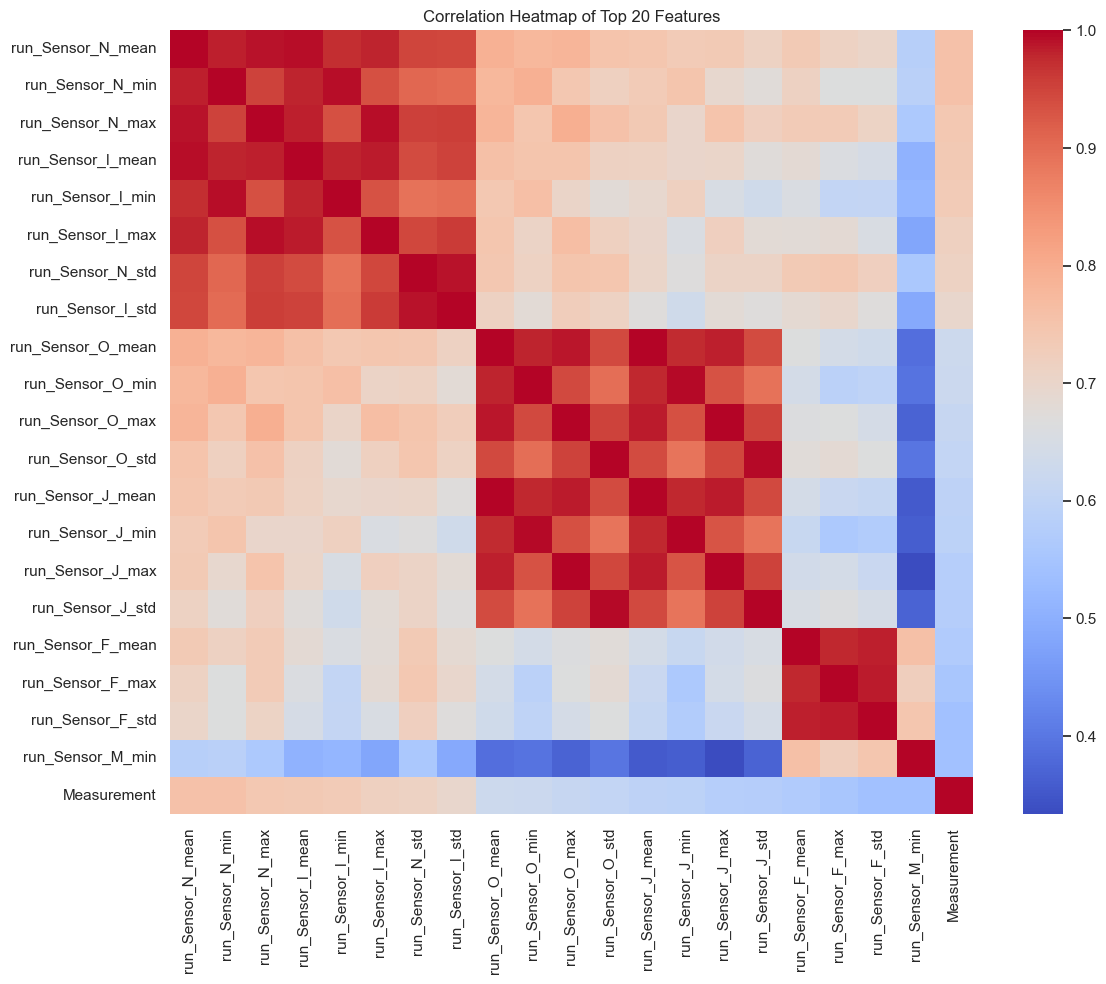

In [29]:
# Visualize top correlations
top_features = target_corr.abs().sort_values(ascending=False).head(20).index.tolist()
sns.set(rc={"figure.figsize": (12, 10)})
sns.heatmap(correlation_df[top_features + ['Measurement']].corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of Top 20 Features")
plt.tight_layout()
plt.show()

#### Inference:
1. Highly Correlated Features:
- Sensors N, I, and O (mean, min, max, std) form strong internal clusters — very high correlations among their statistics.
- Sensor_J features are also strongly correlated within themselves and with Sensor_O.
- Sensor_F_mean/max/std are also reasonably correlated with the target (Measurement), especially F_mean.

2. Less Correlated / Possibly Informative Features:
- run_Sensor_M_min is weakly correlated with everything else — could either be noise or an orthogonal signal.
- Features like Sensor_F_mean and Sensor_O_mean appear to correlate relatively well with the target.

3. Potential Redundancy:
- Due to high inter-correlations (e.g., mean, min, and max of the same sensor), some features could be dropped or transformed to reduce multicollinearity

## Training model on raw preprocessed data

In [43]:
# Ensure datetime columns are properly parsed
for col in ["Run Start Time", "Run End Time"]:
    if final_df[col].dtype != "datetime64[ns]":
        final_df[col] = pd.to_datetime(final_df[col], errors='coerce')

# Compute run duration in seconds
final_df["run_duration"] = (final_df["Run End Time"] - final_df["Run Start Time"]).dt.total_seconds()

# Optional: time since start (per sensor reading)
if "Time Stamp" in final_df.columns:
    final_df["time_since_start"] = (final_df["Time Stamp"] - final_df["Run Start Time"]).dt.total_seconds()


In [44]:
# Train-Test Split by Run ID
run_ids = final_df['Run ID'].unique()
train_ids, val_ids = train_test_split(run_ids, test_size=0.2, random_state=42)
train_df = final_df[final_df['Run ID'].isin(train_ids)].copy()
val_df = final_df[final_df['Run ID'].isin(val_ids)].copy()

In [45]:
# Prepare features and target
datetime_cols = final_df.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
non_features = ['Run ID', 'Measurement', 'X', 'Y', 'X_index', 'Y_index', 'Point Index']
feature_cols = [col for col in final_df.columns if col not in non_features + datetime_cols]


X_train = train_df[feature_cols]
y_train = train_df['Measurement']
X_val = val_df[feature_cols]
y_val = val_df['Measurement']

In [46]:
# Train LightGBM baseline model
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [47]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42
}

In [48]:
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)



Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.0875484	valid_1's rmse: 0.092233
[200]	training's rmse: 0.0866887	valid_1's rmse: 0.0917663
[300]	training's rmse: 0.0864859	valid_1's rmse: 0.0916936
Early stopping, best iteration is:
[288]	training's rmse: 0.0864959	valid_1's rmse: 0.0916727


In [54]:
from sklearn.metrics import mean_squared_error

# Step 9: Evaluate RMSE
preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f"\n✅ Baseline LightGBM RMSE on validation set: {rmse:.5f}")


✅ Baseline LightGBM RMSE on validation set: 0.09167


## Feature Engineered Model

#### Feature engineering

In [5]:
final_df = pd.read_parquet("preprocessed_data/final_df.parquet")

In [6]:
# Sensor differences (interactions)
final_df["diff_F_O_mean"] = final_df["run_Sensor_F_mean"] - final_df["run_Sensor_O_mean"]
final_df["diff_N_I_mean"] = final_df["run_Sensor_N_mean"] - final_df["run_Sensor_I_mean"]


In [7]:
# Sensor ratios
final_df["ratio_N_I_mean"] = final_df["run_Sensor_N_mean"] / (final_df["run_Sensor_I_mean"] + 1e-5)


In [9]:
# Ranges (max - min)
final_df["range_Sensor_F"] = final_df["run_Sensor_F_max"] - final_df["run_Sensor_F_min"]
final_df["range_Sensor_O"] = final_df["run_Sensor_O_max"] - final_df["run_Sensor_O_min"]


In [10]:
#Composite signal strength
sensor_mean_cols = [col for col in final_df.columns if col.endswith("_mean") and col.startswith("run_Sensor_")]
final_df["total_sensor_mean"] = final_df[sensor_mean_cols].sum(axis=1)

In [12]:
#final df checks
final_df.nunique().sort_values()

Y_index                  30
Y                        30
X_index                  33
X                        33
Point Index              49
                      ...  
in_Sensor_28_mean      4140
in_Sensor_27_mean      4140
in_Sensor_22_std       4140
Run ID                 4140
Measurement          202860
Length: 239, dtype: int64

In [13]:
# Drop columns with too many nulls (threshold = 90%)
null_thresh = 0.9
final_df = final_df.loc[:, final_df.isnull().mean() < null_thresh]


In [15]:
# Drop rows where target is missing (shouldn't happen, but safe)
final_df = final_df[final_df["Measurement"].notnull()].copy()

In [17]:
# Save Feature Engineered DF
save_dir = "feature_engineered"
os.makedirs(save_dir, exist_ok=True)
final_df.to_parquet(os.path.join(save_dir, "final_df_feature_engineered.parquet"))
print(f"\n Feature-engineered DataFrame saved to: {save_dir}")


 Feature-engineered DataFrame saved to: feature_engineered


In [18]:
# Define Features
non_features = ['Run ID', 'Measurement', 'X', 'Y', 'X_index', 'Y_index', 'Point Index']
datetime_cols = final_df.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
feature_cols = [col for col in final_df.columns if col not in non_features + datetime_cols]


In [19]:
# Train/Val Split
run_ids = final_df['Run ID'].unique()
train_ids, val_ids = train_test_split(run_ids, test_size=0.2, random_state=42)
train_df = final_df[final_df['Run ID'].isin(train_ids)]
val_df = final_df[final_df['Run ID'].isin(val_ids)]

In [20]:
X_train = train_df[feature_cols]
y_train = train_df['Measurement']
X_val = val_df[feature_cols]
y_val = val_df['Measurement']

In [21]:
#  Train LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [22]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
}


In [23]:
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.0875351	valid_1's rmse: 0.0920141
[200]	training's rmse: 0.0866906	valid_1's rmse: 0.0915745
Early stopping, best iteration is:
[229]	training's rmse: 0.0866081	valid_1's rmse: 0.0915424


In [25]:
# rmse
rmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val)))
print(f"\n📉 LightGBM RMSE with feature engineering: {rmse:.5f}")



📉 LightGBM RMSE with feature engineering: 0.09154


#### inferemce :
- This is a small improvement (~0.13% drop in RMSE), so while the engineered features added a bit of signal, they didn't drastically enhance model performance.
- This suggests one or more of the following:
1. The original features were already highly predictive.
2. The added features (differences, ratios, ranges) had limited incremental value.
3. The model may be underfitting or hitting its performance ceiling on this feature space.

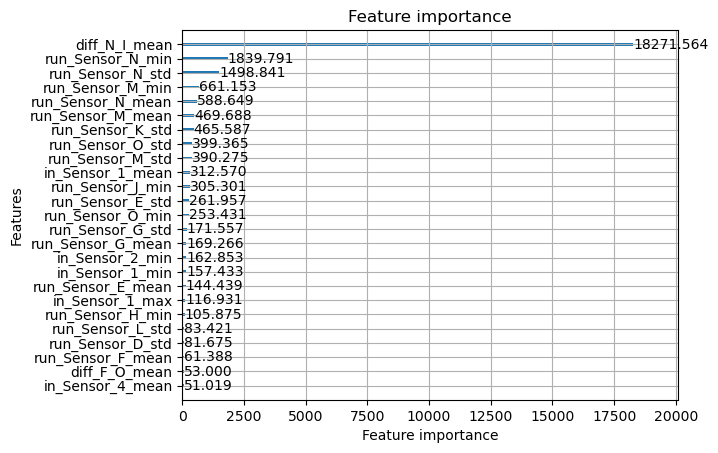

In [26]:
#Use LightGBM’s Feature Importance
lgb.plot_importance(model, max_num_features=25, importance_type='gain')
plt.show()

#### inference:
 Top Features
 1. diff_N_I_mean
➤ This engineered feature completely dominates the importance (18,271), far beyond any other — it’s the most informative signal.
2. run_Sensor_N_min, run_Sensor_N_std, run_Sensor_N_mean
➤ These are highly important, reinforcing that Sensor_N’s behavior (especially min and variability) has strong influence on Measurement.
3. run_Sensor_M_min, run_Sensor_M_mean
➤ Sensor_M also contributes solid signal.
4. in_Sensor_1_mean, in_Sensor_1_min
➤ Sensor 1 from incoming data matters — so including both pre-process and in-process features is paying off.
5. diff_F_O_mean, run_Sensor_F_mean
➤ These engineered features add value, though smaller.

#### Takeaway:

1. the engineered features were effective: diff_N_I_mean is hugely important.
2. Sensor_N, Sensor_M, Sensor_1 are key drivers — focus further engineering here.
3. Many other features had minimal impact — next round we can consider pruning or dimensionality reduction.

#### Xgboost Model Comparison

In [29]:
# Reuse train/val splits from LightGBM pipeline
X_train_xgb = X_train.copy()
X_val_xgb = X_val.copy()
y_train_xgb = y_train.copy()
y_val_xgb = y_val.copy()

In [30]:
# Define XGBoost DMatrix
train_dmatrix = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
val_dmatrix = xgb.DMatrix(X_val_xgb, label=y_val_xgb)

In [31]:
# Set Parameters
xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "seed": 42,
    "verbosity": 0
}

In [32]:
# Train with early stopping
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=train_dmatrix,
    num_boost_round=1000,
    evals=[(train_dmatrix, "train"), (val_dmatrix, "val")],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-rmse:0.16403	val-rmse:0.16399
[100]	train-rmse:0.08708	val-rmse:0.09257
[200]	train-rmse:0.08661	val-rmse:0.09221
[300]	train-rmse:0.08647	val-rmse:0.09214
[400]	train-rmse:0.08641	val-rmse:0.09209
[500]	train-rmse:0.08638	val-rmse:0.09211
[504]	train-rmse:0.08638	val-rmse:0.09210


In [33]:
# Evaluate
xgb_preds = xgb_model.predict(val_dmatrix)
xgb_rmse = np.sqrt(mean_squared_error(y_val_xgb, xgb_preds))
print(f"\n📉 XGBoost RMSE on validation set: {xgb_rmse:.5f}")



📉 XGBoost RMSE on validation set: 0.09210


#### Catboost Model Comparison

In [35]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 5.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [37]:
#  Detect categorical features by column names (if present)
categorical_features = []
for col in ['Tool ID', 'Step ID']:
    if col in X_train.columns:
        categorical_features.append(col)

In [38]:
# Define CatBoost Pool
dtrain_cb = Pool(data=X_train, label=y_train, cat_features=categorical_features)
dval_cb = Pool(data=X_val, label=y_val, cat_features=categorical_features)


In [39]:
# Set Parameters
catboost_params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": 42,
    "early_stopping_rounds": 50,
    "verbose": 100
}

In [40]:
# Train
cat_model = CatBoostRegressor(**catboost_params)
cat_model.fit(dtrain_cb, eval_set=dval_cb)

0:	learn: 0.1646143	test: 0.1642802	best: 0.1642802 (0)	total: 93.3ms	remaining: 1m 33s
100:	learn: 0.0905813	test: 0.0924913	best: 0.0924676 (99)	total: 2.83s	remaining: 25.2s
200:	learn: 0.0888103	test: 0.0917122	best: 0.0917114 (199)	total: 5.21s	remaining: 20.7s
300:	learn: 0.0878905	test: 0.0911982	best: 0.0911982 (300)	total: 7.62s	remaining: 17.7s
400:	learn: 0.0873455	test: 0.0909337	best: 0.0909337 (400)	total: 10.1s	remaining: 15s
500:	learn: 0.0870092	test: 0.0908013	best: 0.0908013 (500)	total: 12.5s	remaining: 12.5s
600:	learn: 0.0868012	test: 0.0907268	best: 0.0907266 (599)	total: 14.9s	remaining: 9.87s
700:	learn: 0.0866653	test: 0.0906646	best: 0.0906646 (700)	total: 17.2s	remaining: 7.33s
800:	learn: 0.0865699	test: 0.0906333	best: 0.0906322 (798)	total: 19.5s	remaining: 4.84s
900:	learn: 0.0865015	test: 0.0905975	best: 0.0905944 (895)	total: 21.8s	remaining: 2.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.09059440348
bestIteration = 895

Shrin

In [41]:
# Evaluate
cat_preds = cat_model.predict(X_val)
cat_rmse = np.sqrt(mean_squared_error(y_val, cat_preds))
print(f"\n📉 CatBoost RMSE on validation set: {cat_rmse:.5f}")


📉 CatBoost RMSE on validation set: 0.09059
